# FSI TimeMarching test

In [1]:
include("../src/FSI.jl")
using FSI

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [48]:
include(Pkg.dir("Dyn3d")*"/src/config_files/2dFall.jl")

Config info set up.


#### Build joint-body chain

In [49]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is fixed in space

#### Initialize rigid body system state to complete body-joint information

In [50]:
bd, soln₀ = InitSystem!(bd)

(, Dyn3d.ConstructSystem.Soln{Float64}(0.0, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float64[], Float64[]))

This is a 1 body-joint system, system is fixed in space

#### Initialize u and λ container

In [51]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [52]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only


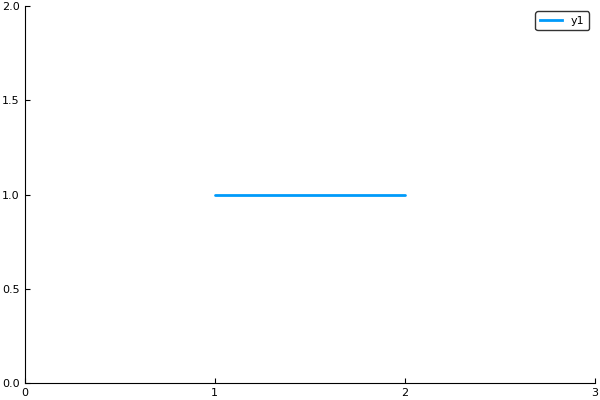

In [53]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,3), ylims=(0,2))

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [54]:
Re = 200 # Reynolds number
U = 1.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 1.0)

#### Set the domain grid

In [55]:
nx = 152; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:3.0100000000000002, -0.01:0.02:2.0100000000000002)

#### Set up fluid initial conditions

In [56]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Genrate body grid points and get linear velocity on them

In [57]:
# bgs short for body grid system
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx))
bgs = CutOut2d(bd,bgs);

#### Get body points initial coordinates for fluids

In [58]:
bgs = AcquireBodyGridKinematics(bd,bgs)
coord_init = hcat(bgs[1].q_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord_init = [coord_init[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
end

#### Set up body grid points and force container in fluid

In [59]:
X̃ = VectorData(coord_init)
f = VectorData(X̃);

#### Create fluidstruct structure

In [60]:
tf = Δt
T = Δt:Δt:tf
fsys = Systems.FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

51

## <span style="color:blue"> Create ifherk object </span>

In [61]:
ifherk_coupled = FSI.IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys),
                 (f,X̃) -> B₁ᵀ(f,X̃,fsys),
                 (w,X̃) -> B₂(w,X̃,fsys)),
                (bd -> M⁻¹(bd), bd -> G₁ᵀ(bd), bd -> G₂(bd),
                 (bd,qJ) -> UpP(bd,qJ), (bd,v) -> UpV(bd,v)),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx),
                 (bd,bgs,v) -> T₂(bd,bgs,v),
                 (bd,bgs) -> getX̃(bd,bgs)),
                ((w,t) -> r₁(w,t,fsys),
                 bd -> F(bd), (bd,t) -> gti(bd,t)),
                tol=1e-3,rk=Whirl.TimeMarching.RK31)

Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [62]:
fx = Float64[]
fy = Float64[]
thist = []
whist = []
bdhist = BodyDyn[];

In [103]:
@time T₁ᵀ(bd, bgs, f, Δx)

  0.000240 seconds (2.92 k allocations: 338.313 KiB)


6-element Array{Float64,1}:
  1.47313e-9 
 -9.20201e-12
 -0.922613   
  0.000610603
 -0.586447   
  0.0        

In [102]:
@time T₂(bd, bgs, v)

  0.000131 seconds (625 allocations: 74.656 KiB)


51 points of vector-valued data
 -1.69893e-6  1.59065e-6 
 -1.71499e-6  0.000255138
 -1.73104e-6  0.000508686
 -1.7471e-6   0.000762233
 -1.76315e-6  0.00101578 
 -1.77921e-6  0.00126933 
 -1.79526e-6  0.00152288 
 -1.81132e-6  0.00177642 
 -1.82737e-6  0.00202997 
 -1.84343e-6  0.00228352 
 -1.85948e-6  0.00253706 
 -1.87554e-6  0.00279061 
 -1.89159e-6  0.00304416 
  ⋮                      
 -2.32507e-6  0.00988994 
 -2.34113e-6  0.0101435  
 -2.35718e-6  0.010397   
 -2.37324e-6  0.0106506  
 -2.38929e-6  0.0109041  
 -2.40535e-6  0.0111577  
 -2.4214e-6   0.0114112  
 -2.43746e-6  0.0116648  
 -2.45351e-6  0.0119183  
 -2.46956e-6  0.0121719  
 -2.48562e-6  0.0124254  
 -2.50167e-6  0.012679   

In [101]:
@time getX̃(bd, bgs)

  0.000080 seconds (378 allocations: 48.797 KiB)


51 points of vector-valued data
 1.0   1.0    
 1.02  1.0    
 1.04  1.0    
 1.06  1.0    
 1.08  1.00001
 1.1   1.00001
 1.12  1.00001
 1.14  1.00001
 1.16  1.00001
 1.18  1.00001
 1.2   1.00001
 1.22  1.00001
 1.24  1.00002
 ⋮            
 1.78  1.00005
 1.8   1.00005
 1.82  1.00005
 1.84  1.00005
 1.86  1.00005
 1.88  1.00006
 1.9   1.00006
 1.92  1.00006
 1.94  1.00006
 1.96  1.00006
 1.98  1.00006
 2.0   1.00006

## <span style="color:blue"> TimeMarching! </span>

In [78]:
Profile.clear()

In [80]:
@time for t in T
    
    @profile t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("t is ",t)
end

t is 0.02
222.573415 seconds (3.26 G allocations: 600.314 GiB, 29.17% gc time)


In [98]:
bd.sys

ndim = 2, njoint = 1, nbody = 1
ndof = 6, nudof = 1, ncdof = 5, np = 1, na = 0
udof = [3]
udof_p = [3]
udof_a = Int64[]
nudof_HERK = 1, ncdof_HERK = 5
udof_HERK = [3]
gravity = [0.0, -1.0, 0.0]


In [82]:
Profile.print()

before your program finished. To profile for longer runs, call Profile.init
with a larger buffer and/or larger delay.


16156 ./task.jl:335; (::IJulia.##13#16)()
 16156 ...ulia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  16156 ...Compat/src/Compat.jl:189; (::Compat.#inner#6{Array{Any,1}...
   16156 ...c/execute_request.jl:193; execute_request(::ZMQ.Socket, ...
    16156 ./loading.jl:522; include_string(::String, ::String)
     16156 ./<missing>:?; anonymous
      16156 ./util.jl:237; macro expansion
       16156 ./In[80]:3; macro expansion
        16156 ./profile.jl:23; macro expansion
         147   ./inference.jl:2622; typeinf_ext(::Core.MethodI...
          147 ./inference.jl:2583; typeinf_code(::Core.MethodI...
           147 ./inference.jl:2504; typeinf_frame(::Core.Metho...
            28  ./inference.jl:2787; typeinf(::Core.Inference.I...
             27 ./inference.jl:2669; typeinf_work(::Core.Infere...
              22 ./inference.jl:2076; abstract_interpret(::Any,...
               22 ./inference.jl:1950; abstract_eval(::Any, ::A...
                22 ./inference.jl:1927; abstract_eval_call(

                         1 ./generator.jl:45; next(::Core.Inferenc...
                  1 ./inference.jl:2816; typeinf(::Core.Inferenc...
                   1 ./inference.jl:2905; optimize(::Core.Inferen...
                    1 ./inference.jl:4265; inlining_pass!(::Core....
                     1 ./inference.jl:4327; inlining_pass(::Expr,...
                      1 ./inference.jl:4327; inlining_pass(::Expr,...
                       1 ./inference.jl:4428; inlining_pass(::Expr...
                        1 ./inference.jl:3889; inlineable(::Any, ::...
                         1 ./inference.jl:2504; typeinf_frame(::Cor...
                          1 ./inference.jl:2817; typeinf(::Core.Inf...
                           1 ./inference.jl:3022; finish(::Core.Infe...
                 1 ./inference.jl:4046; inlineable(::Any, ::Any,...
                  1 ./array.jl:562; getindex
               4 ./inference.jl:4428; inlining_pass(::Expr, ::C...
                1 ./inference.jl:3655; inlineable(

                     1 ./sort.jl:105; searchsortedfirst(::Ar...
                    1 ...parsematrix.jl:2315; setindex!(::SparseMatr...
                    1 ...parsematrix.jl:2322; setindex!(::SparseMatr...
            2 ...e/sparsevector.jl:324; sparsevec(::Array{Float64,2})
             2 ...e/sparsevector.jl:338; _dense2sparsevec(::Array{Fl...
           12  ...regularization.jl:263; Whirl.Fields.Regularization...
            11 ...e/sparsematrix.jl:2503; setindex!(::SparseMatrixCS...
             11 ./abstractarray.jl:968; setindex!
              11 ...ltidimensional.jl:537; _setindex!
               11 ...tidimensional.jl:541; macro expansion
                11 ...tidimensional.jl:549; _unsafe_setindex!(::Inde...
                 11 ...idimensional.jl:556; macro expansion
                  11 ./cartesian.jl:64; macro expansion
                   3 ...idimensional.jl:557; macro expansion
                    3 ./abstractarray.jl:760; next
                     3 ...shapedarray.jl:18

                   13 ./broadcast.jl:141; _broadcast!
                    13 ./broadcast.jl:149; macro expansion
                     1  ./simdloop.jl:68; macro expansion
                     12 ./simdloop.jl:73; macro expansion
                      5 ./broadcast.jl:153; macro expansion
                      2 ./broadcast.jl:155; macro expansion
                      5 ./broadcast.jl:156; macro expansion
                       5 ...imensional.jl:300; setindex!
               94  ./broadcast.jl:206; broadcast!
                2  ./broadcast.jl:210; broadcast_c!
                 1 ./broadcast.jl:89; check_broadcast_indices
                 1 ./broadcast.jl:0; check_broadcast_shape(::T...
                86 ./broadcast.jl:213; broadcast_c!
                 2  ./broadcast.jl:0; _broadcast!(::Whirl.Fiel...
                 39 ./broadcast.jl:141; _broadcast!(::Whirl.Fiel...
                  39 ./broadcast.jl:149; macro expansion
                   1  ./simdloop.jl:72; macro expansion
     

                     3 ./inference.jl:1950; abstract_eval(::Any, ...
                      3 ./inference.jl:1927; abstract_eval_call(::...
                       3 ./inference.jl:1870; abstract_call(::Any,...
                    6 ./inference.jl:2084; abstract_interpret(::A...
                     6 ./inference.jl:1950; abstract_eval(::Any, ...
                      3 ./inference.jl:1901; abstract_eval_call(::...
                       3 ./array.jl:393; collect(::Type{Any}, ...
                        3 ./array.jl:396; _collect(::Type{Any}...
                         3 ...tractarray.jl:573; copy!(::Array{Any,1}...
                          3 ./generator.jl:45; next(::Core.Inferenc...
                           3 ./<missing>:0; (::Core.Inference.##...
                            3 ./inference.jl:1950; abstract_eval(::A...
                             3 ./inference.jl:1927; abstract_eval_cal...
                              3 ...ference.jl:1897; abstract_call(::...
                      

                                        1 ...nce.jl:3290; occurs_mor...
                                     +1 1 ...nce.jl:3287; occurs_mor...
                                    1 ...rence.jl:2907; optimize(::C...
                                     1 ...ence.jl:5197; alloc_elim_p...
                                      1 ...ence.jl:4750; occurs_outs...
                                       1 ...ence.jl:4750; occurs_outs...
                                        1 ...nce.jl:4726; occurs_out...
                                 1 ...erence.jl:1421; abstract_call_...
                                  1 ...erence.jl:2365; add_backedge!(...
                            1 ./inference.jl:2816; typeinf(::Core.In...
                             1 ./inference.jl:2905; optimize(::Core.I...
                              1 ...ference.jl:4265; inlining_pass!(:...
                               1 ...ference.jl:4327; inlining_pass(:...
                                1 ...erence.jl:4327; inlining

                          1 ./inference.jl:1420; abstract_call_gf_b...
                           1 ./inference.jl:2535; typeinf_edge(::Met...
                            1 ./inference.jl:2816; typeinf(::Core.In...
                             1 ./inference.jl:2905; optimize(::Core.I...
                              1 ...ference.jl:4265; inlining_pass!(:...
                               1 ...ference.jl:4428; inlining_pass(:...
                                1 ...erence.jl:3770; inlineable(::An...
                                 1 ./array.jl:207; getindex
                      17 ./inference.jl:2084; abstract_interpret(:...
                       17 ./inference.jl:1950; abstract_eval(::Any,...
                        17 ./inference.jl:1927; abstract_eval_call(...
                         17 ./inference.jl:1897; abstract_call(::An...
                          17 ./inference.jl:1420; abstract_call_gf_b...
                           17 ./inference.jl:2535; typeinf_edge(::Me...
         

                     13546 ...intSystems.jl:113; (::FSI.SaddlePointSy...
                      3     ./inference.jl:2622; typeinf_ext(::Core...
                       3 ./inference.jl:2583; typeinf_code(::Core....
                        3 ./inference.jl:2504; typeinf_frame(::Core...
                         3 ./inference.jl:2816; typeinf(::Core.Infe...
                          3 ./inference.jl:2905; optimize(::Core.In...
                           3 ./inference.jl:4265; inlining_pass!(::C...
                            3 ./inference.jl:4327; inlining_pass(::E...
                             3 ./inference.jl:4428; inlining_pass(::E...
                              1 ...ference.jl:4089; inlineable(::Any...
                               1 ./array.jl:548; next(::Array{Any...
                              1 ...ference.jl:4185; inlineable(::Any...
                              1 ...ference.jl:4194; inlineable(::Any...
                      13529 ./operators.jl:884; (::Base.##55#56{Ba...
 

                           7  ./reduce.jl:0; mapreduce_impl(::B...
                           1  ./reduce.jl:180; mapreduce_impl(::B...
                           4  ./reduce.jl:181; mapreduce_impl(::B...
                           1  ./reduce.jl:183; mapreduce_impl(::B...
                           1  ./reduce.jl:185; mapreduce_impl(::B...
                           85 ./reduce.jl:186; mapreduce_impl(::B...
                            2  ./simdloop.jl:65; macro expansion
                            2  ./simdloop.jl:66; macro expansion
                            10 ./simdloop.jl:71; macro expansion
                            71 ./simdloop.jl:73; macro expansion
                             25 ./reduce.jl:187; macro expansion
                             46 ./reduce.jl:188; macro expansion
                           2  ./reduce.jl:190; mapreduce_impl(::B...
                         3    ...rization.jl:205; (::Whirl.Fields.Re...
                          3 ./array.jl:228; fill!(::Array

                                      4 ./sort.jl:107; searchsorted...
                                    1  ...ector.jl:687; _spgetindex(...
                                35 ...sional.jl:558; macro expansion
                                 4  ...matrix.jl:0; setindex!(::Sp...
                                 1  ...matrix.jl:2302; setindex!(::Sp...
                                 5  ...matrix.jl:2305; setindex!(::Sp...
                                 3  ...matrix.jl:2306; setindex!(::Sp...
                                 15 ...matrix.jl:2307; setindex!(::Sp...
                                  1  ./sort.jl:0; searchsortedfi...
                                  11 ./sort.jl:105; searchsortedfi...
                                  1  ./sort.jl:106; searchsortedfi...
                                 2  ...matrix.jl:2311; setindex!(::Sp...
                                 1  ...matrix.jl:2315; setindex!(::Sp...
                                 1  ...matrix.jl:2322; setindex!(::Sp...

                                21  ...adcast.jl:151; macro expansion
                                57  ...adcast.jl:153; macro expansion
                                305 ...adcast.jl:155; macro expansion
                                 280 ...ds/ddf.jl:50; DDF
                                  175 ...ds/ddf.jl:62; ddf_roma
                                   7  ...ds/ddf.jl:59; roma1
                                   41 ...ds/ddf.jl:60; roma2
                                25  ...adcast.jl:156; macro expansion
                                 25 ...sional.jl:300; setindex!
                               13  ./simdloop.jl:74; macro expansion
                          1343 ...rization.jl:203; (::Whirl.Fields.R...
                           1252 ...owvector.jl:207; At_mul_B
                            34   ...ctarray.jl:1936; map
                             34 ./generator.jl:36; Type
                            6    ./array.jl:0; collect(::Base....
                            9  

                             2  ./simdloop.jl:66; macro expansion
                             1  ./simdloop.jl:68; macro expansion
                             9  ./simdloop.jl:71; macro expansion
                             80 ./simdloop.jl:73; macro expansion
                              17 ./reduce.jl:187; macro expansion
                              63 ./reduce.jl:188; macro expansion
                            1  ./reduce.jl:190; mapreduce_impl(::...
                         103  ...rization.jl:262; Whirl.Fields.Regul...
                          92 ...sematrix.jl:2503; setindex!(::Sparse...
                           92 ...actarray.jl:968; setindex!
                            92 ...ensional.jl:537; _setindex!
                             92 ...ensional.jl:541; macro expansion
                              91 ...nsional.jl:549; _unsafe_setindex...
                               91 ...nsional.jl:556; macro expansion
                                2  ...rtesian.jl:62; macro e

                                   3 ...rence.jl:2535; typeinf_edge(...
                                    3 ...rence.jl:2787; typeinf(::Co...
                                     3 ...ence.jl:2722; typeinf_work...
                                      3 ...ence.jl:1950; abstract_ev...
                                       3 ...ence.jl:1901; abstract_ev...
                                        3 ./array.jl:393; collect(::T...
                                     +1 3 ./array.jl:396; _collect(::...
                                     +2 3 ...rray.jl:573; copy!(::Arr...
                                     +3 3 ...ator.jl:45; next(::Core...
                                     +4 3 ...issing>:0; (::Core.Infe...
                                     +5 3 ...nce.jl:1950; abstract_e...
                                     +6 3 ...nce.jl:1927; abstract_e...
                                     +7 3 ...nce.jl:1897; abstract_c...
                                     +8 3 ...nce.jl:1420; ab

                                     +9 1 ./array.jl:393; collect(::T...
                                    +10 1 ./array.jl:396; _collect(::...
                                    +11 1 ...rray.jl:573; copy!(::Arr...
                                    +12 1 ...ator.jl:45; next(::Core...
                                    +13 1 ...issing>:0; (::Core.Infe...
                                    +14 1 ...nce.jl:1950; abstract_e...
                                    +15 1 ...nce.jl:1901; abstract_e...
                                    +16 1 ./array.jl:393; collect(::T...
                                    +17 1 ./array.jl:396; _collect(::...
                                    +18 1 ...rray.jl:573; copy!(::Arr...
                                    +19 1 ...ator.jl:45; next(::Core...
                                     +5 110 ...ce.jl:2722; typeinf_w...
                                     +6 110 ...ce.jl:1950; abstract_...
                                     +7 110 ...ce.jl:1927;

                                    +57 10 ...issing>:0; (::Core.Inf...
                                    +58 10 ...nce.jl:1950; abstract_...
                                    +59 10 ...nce.jl:1922; abstract_...
                                    +60 10 ...nce.jl:1420; abstract_...
                                    +61 10 ...nce.jl:2535; typeinf_e...
                                    +62 4 ...nce.jl:2787; typeinf(::...
                                    +63 4 ...nce.jl:2722; typeinf_wo...
                                    +64 4 ...nce.jl:1950; abstract_e...
                                    +65 4 ...nce.jl:1901; abstract_e...
                                    +66 4 ./array.jl:393; collect(::T...
                                    +67 4 ./array.jl:396; _collect(::...
                                    +68 4 ...rray.jl:573; copy!(::Arr...
                                    +69 4 ...ator.jl:45; next(::Core...
                                    +70 4 ...issing>:0; (::Co

                                    +31 1 ...nce.jl:1870; abstract_c...
                                    +32 1 ...ence.jl:328; anymap(::Co...
                                    +31 2 ...nce.jl:1897; abstract_c...
                                    +32 1 ...nce.jl:1311; abstract_c...
                                    +33 1 ...tion.jl:521; _methods_by...
                                    +32 1 ...nce.jl:1420; abstract_c...
                                    +33 1 ...nce.jl:2535; typeinf_ed...
                                    +34 1 ...nce.jl:2817; typeinf(::...
                                    +35 1 ...nce.jl:3026; finish(::C...
                                    +26 14 ...nce.jl:2816; typeinf(:...
                                    +27 3  ...nce.jl:2905; optimize(...
                                    +28 3 ...nce.jl:4265; inlining_p...
                                    +29 3 ...nce.jl:4428; inlining_p...
                                    +30 1 ...nce.jl:3771; inli

                                     +6 5 ...nce.jl:1950; abstract_e...
                                     +7 5 ...nce.jl:1927; abstract_e...
                                     +8 5 ...nce.jl:1897; abstract_c...
                                     +9 5 ...nce.jl:1311; abstract_c...
                                    +10 5 ...tion.jl:521; _methods_by...
                                        1 ...nce.jl:1927; abstract_e...
                                     +1 1 ...nce.jl:1897; abstract_c...
                                     +2 1 ...nce.jl:1311; abstract_c...
                                     +3 1 ...tion.jl:521; _methods_by...
                                    14  ...ence.jl:2816; typeinf(::C...
                                     1 ...ence.jl:2894; optimize(::C...
                                      1 ...ence.jl:3145; type_annota...
                                       1 ...ence.jl:3059; annotate_sl...
                                        1 ...nce.jl:3060; ann

## <span style="color:blue"> Plot </span>

In [83]:
bs, js, sys = UpdatePosition!(bd.bs, bd.js, bd.sys, qJ)
vshist = VertsHistory(bd.sys.nbody, bs);


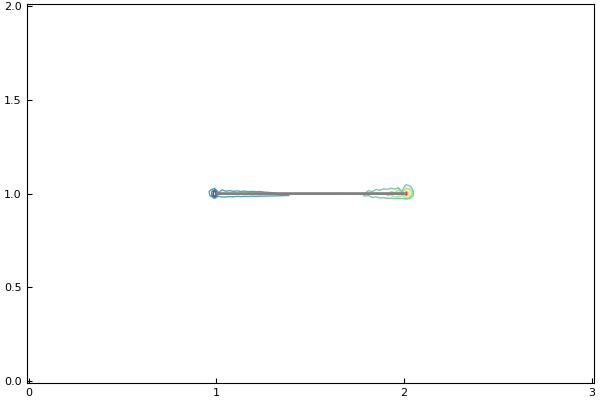

In [84]:
p = plot(xg,yg,w)
for i = 1:bd.sys.nbody
    plot!(p,vshist[i,2:3,1], vshist[i,2:3,2],linewidth=2,linecolor="grey")
end
p


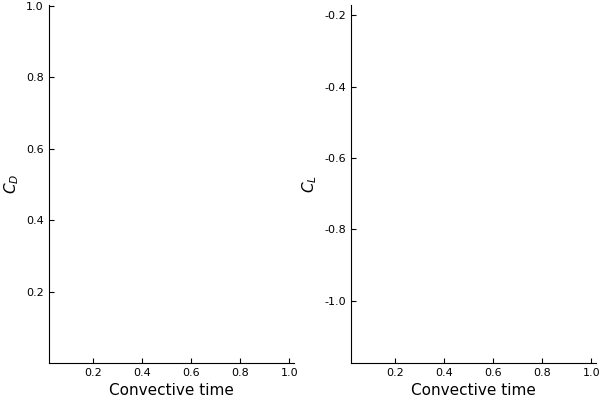

In [85]:
px = plot(thist,2*fx,xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

In [86]:
w[50:70,50:52]

21×3 Array{Float64,2}:
 -0.000529778  0.00646521  0.00854479
 -0.000597973  0.0268423   0.0232411 
  0.000251687  0.00591151  0.00301829
 -0.000283946  0.00886306  0.00836183
  6.35559e-5   0.00802834  0.00547019
 -0.000201534  0.00697562  0.00653464
  2.29697e-5   0.00748892  0.00532276
 -0.000170502  0.00652546  0.00596598
  1.24583e-5   0.00703541  0.00513358
 -0.00016301   0.00623819  0.00562145
  6.02599e-6   0.00667338  0.00498258
 -0.000143104  0.00606962  0.00532716
 -1.66397e-5   0.00630439  0.00485933
 -0.00010763   0.00592606  0.00502656
 -5.26777e-5   0.00594908  0.00476315
 -7.43986e-5   0.00574457  0.00473281
 -7.17828e-5   0.00561904  0.0046181 
 -5.52202e-5   0.00551974  0.00445566
 -7.48254e-5   0.00530895  0.00440218
 -5.69483e-5   0.00520411  0.00422653
 -6.59043e-5   0.0050049   0.00412195

In [87]:
2*fx

1-element Array{Float64,1}:
 0.00122121

In [88]:
2*fy

1-element Array{Float64,1}:
 -1.17289